## Downloading the data

In [1]:
!wget https://github.com/rezpe/kaggleh/blob/main/mobile_price.zip?raw=true
!unzip mobile_price.zip?raw=true

--2021-07-01 16:04:15--  https://github.com/rezpe/kaggleh/blob/main/mobile_price.zip?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rezpe/kaggleh/raw/main/mobile_price.zip [following]
--2021-07-01 16:04:15--  https://github.com/rezpe/kaggleh/raw/main/mobile_price.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rezpe/kaggleh/main/mobile_price.zip [following]
--2021-07-01 16:04:15--  https://raw.githubusercontent.com/rezpe/kaggleh/main/mobile_price.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69877 (

## Loading the dataframe

In [2]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
# We import the test and train datasets
train = pd.read_csv("mobile_price_train.csv")
test = pd.read_csv("mobile_price_test.csv")

In [23]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


## Data Exploration

We will use sweetviz library to display the histograms of the columns

In [24]:
!pip install -q sweetviz

In [25]:
# We check overall distribution of table
import sweetviz as sv

my_report = sv.analyze(train)
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


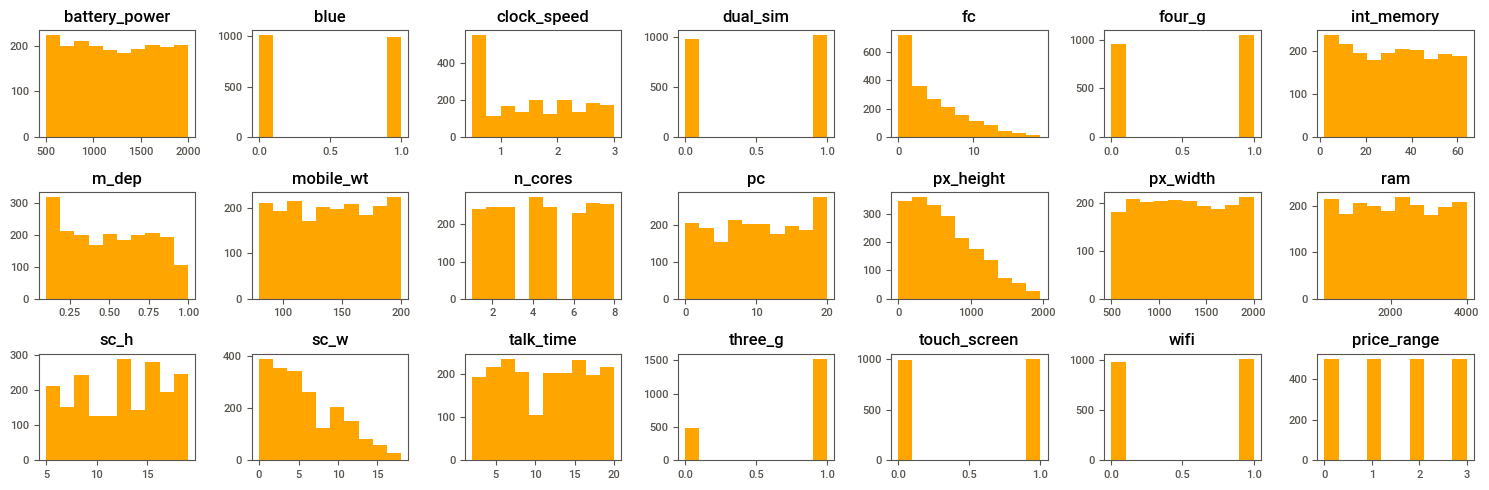

In [26]:
# Alternative method
plt.figure(figsize=(15,5))
cols = train.columns
num_features = len(cols)
num_line = 7
for i,col in enumerate(cols):
  plt.subplot(num_features/num_line,num_line,i+1)
  plt.title(col)
  plt.hist(train[col],color="orange")
plt.tight_layout()

In [27]:
# We check duplicates
train.duplicated().sum()

0

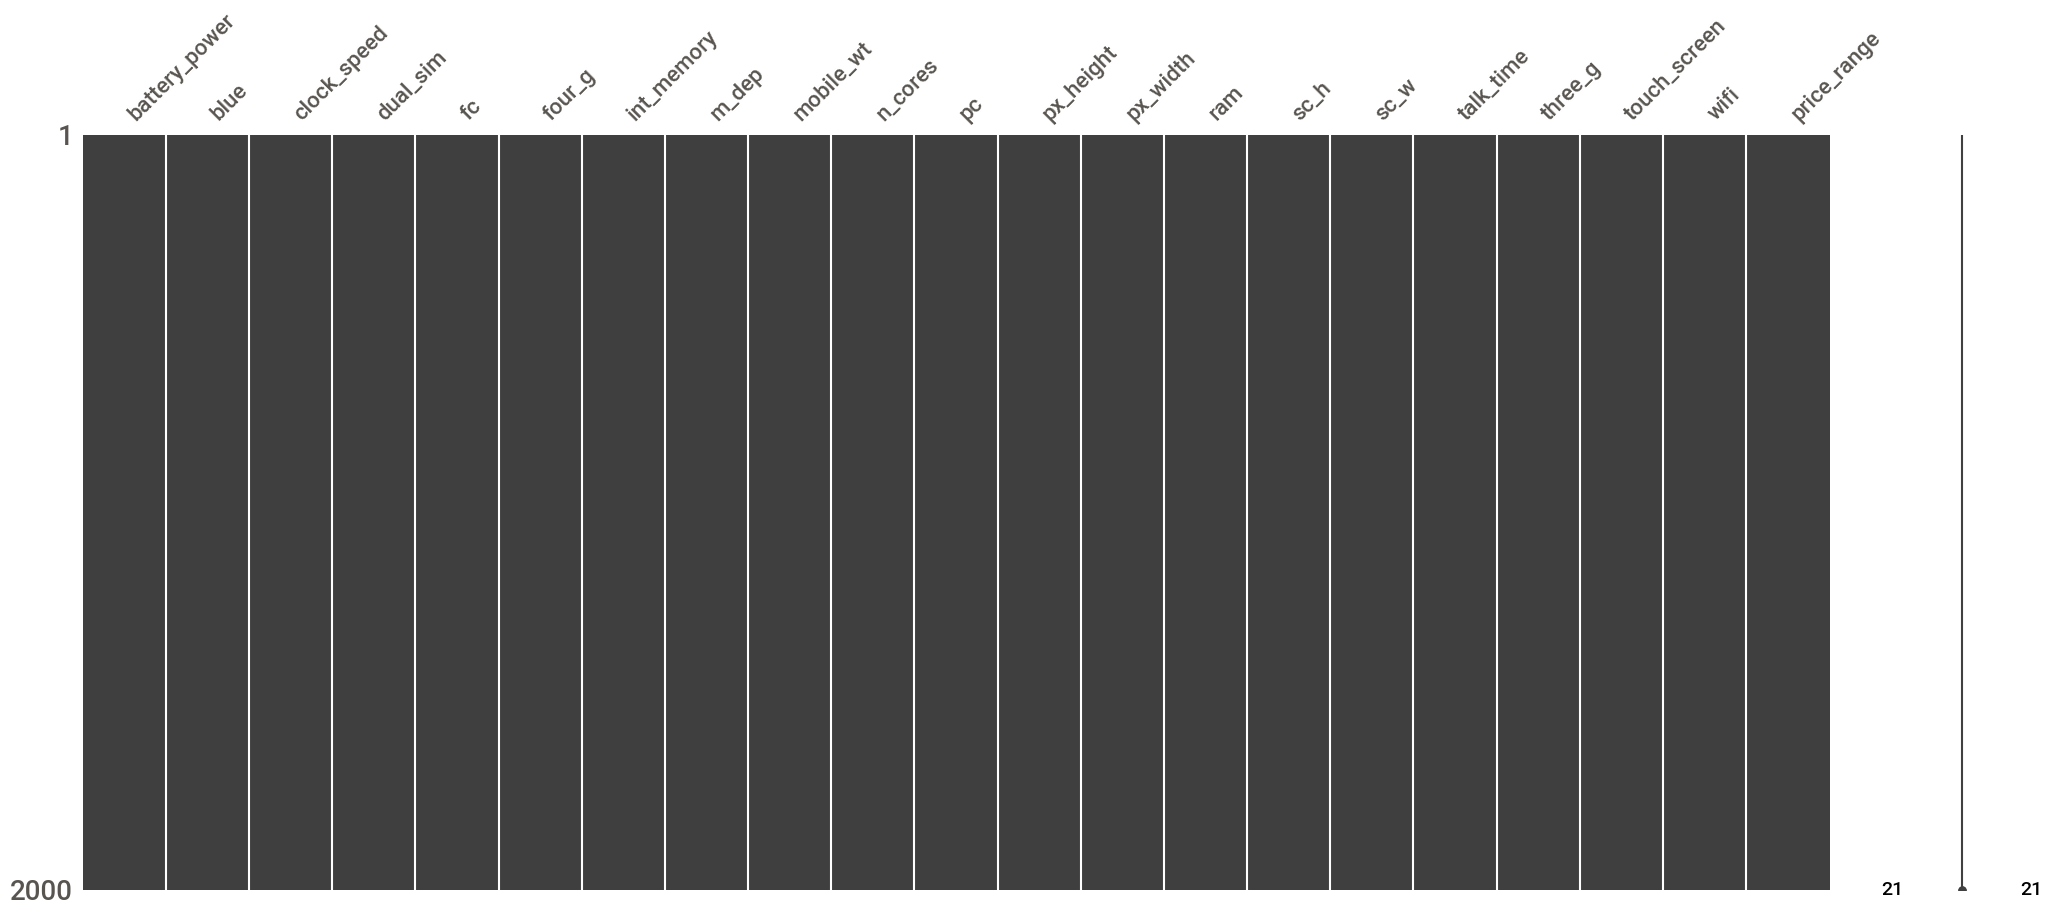

In [28]:
# We check for missing values
import missingno as msno
msno.matrix(train);

## Feature Engineering

In [29]:
# New features
train['Screen diagonal inches'] = np.sqrt(train['sc_h']**2 + train['sc_w']**2) * 0.393701
train['Pixels screen'] = np.sqrt(train['px_height']**2 + train['px_width']**2)

# We calculate pixels per inch (ppi)
train['ppi'] = train['Pixels screen'] / train['Screen diagonal inches']
train.drop(['px_height', 'px_width', 'sc_h', 'sc_w', 'Pixels screen'], axis=1, inplace=True)

# New features
test['Screen diagonal inches'] = np.sqrt(test['sc_h']**2 + test['sc_w']**2) * 0.393701
test['Pixels screen'] = np.sqrt(test['px_height']**2 + test['px_width']**2)

# We calculate pixels per inch (ppi)
test['ppi'] = test['Pixels screen'] / test['Screen diagonal inches']
test.drop(['px_height', 'px_width', 'sc_h', 'sc_w', 'Pixels screen'], axis=1, inplace=True)

In [37]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scaled_train = pd.DataFrame(scaler.fit_transform(train), index = train.index, 
                               columns = train.columns)
scaled_train.drop(['price_range'], axis = 1, inplace = True)

scaled_test = pd.DataFrame(scaler.transform(test), index = test.index, 
                               columns = test.columns)
scaled_test.drop(['id'], axis = 1, inplace = True)

In [12]:
from sklearn.model_selection import train_test_split
X = scaled_train
y = train['price_range']

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

cross_val_score(LogisticRegression(),X,y,cv=3).mean()

0.882001191596394

In [15]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

params = {'learning_rate': np.linspace(0.01,.2,5),
          'n_estimators': [100,200,400],
          'max_depth': np.arange(5,15).astype(int)}

model = GridSearchCV(lgb.LGBMClassifier(),  params, scoring = 'balanced_accuracy', cv = 3)
model.fit(scaled_train, y)
model.best_score_

0.8745100161123537

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Random Forest
params2 = {'n_estimators': [100,200,400],
          'max_depth': np.arange(5,15,2)}
model2 = GridSearchCV(RandomForestClassifier(), params2, cv = 3)
model2.fit(scaled_train, y)
model2.best_score_

0.8439939189564377

In [17]:
# MLP

params3 = {'learning_rate': ['constant', 'invscaling', 'adaptive'],
           'learning_rate_init': np.linspace(0.001,0.005,5)}
model3 = GridSearchCV(MLPClassifier(), params3, cv = 3)
model3.fit(scaled_train, y)
model3.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9045012028520274

## Model Interpretability

In [41]:
mlpmodel = model3.best_estimator_

In [45]:
!pip install -q shap

     |████████████████████████████████| 358kB 13.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=133d491197b65e33c4d8d828152058e463e707c0364d04233a7eb06f4fea9e7b
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [46]:
import shap

In [53]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model.best_estimator_)
shap_values = explainer.shap_values(scaled_test)

In [54]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], scaled_test.iloc[:1000,:])

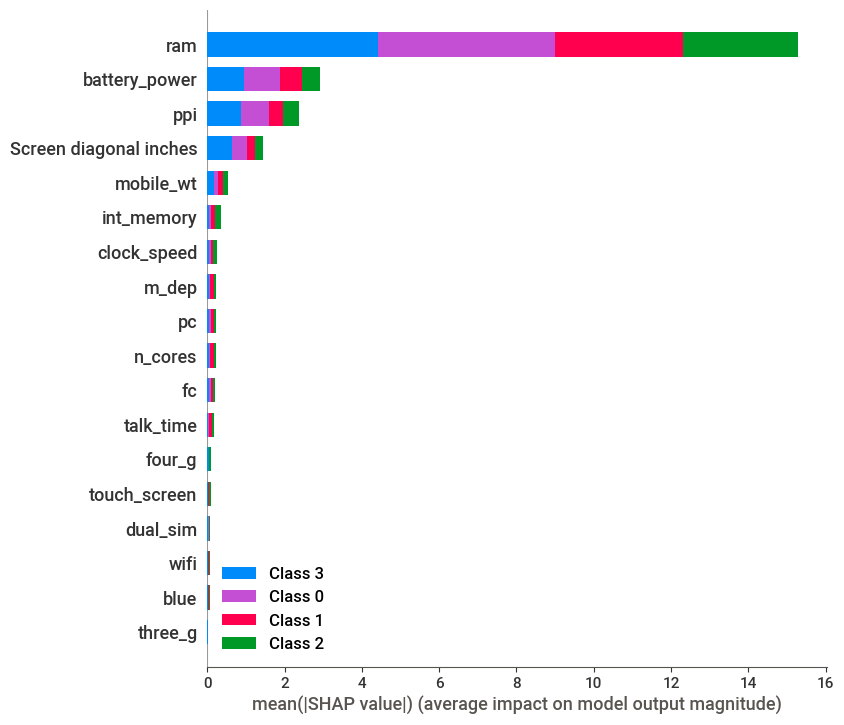

In [52]:
shap.summary_plot(shap_values, X)